# 手动搭建线性模型
此节内容来源于 [徒手实现发向传播算法——分布式训练、GPU运算等](https://www.bilibili.com/video/BV1Xm42157Jr) 。

在上一节中，我们简单实现了反向传播的模型，但是并没有用进行搭建神经网络，我们撰写的代码逻辑实际上和 PyTorch 是差不多的，所以这一节我们用自己的工具来实现神经网络，并且加上可视化的工具。

本节的内容包括：
- 最优化算法
- 计算图膨胀
- 梯度积累
- 参数冻结
- 随机失活 (dropout)

下面的附加内容请移步B站视频学习：
- GPU运算
- 混合精度

In [1]:
from tools.ch07_autograd.utils import Scalar, draw_graph
from tools.ch07_autograd.linear_model import Linear, mse

import torch

torch.manual_seed(1024)  # 使结果可以复现

In [2]:
x = torch.linspace(100, 300, 200)
x = (x - torch.mean(x)) / torch.std(x)
epsilon = torch.randn(x.shape)
y = 10 * x + 5 + epsilon

In [3]:
model = Linear()

batch_size = 20
learning_rate = 0.1

for t in range(20):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]

    # 计算均方误差，虽然我们的代码在训练模型的时候没有用到 Pytorch ，但是我们的测试数据是由 Pytorch 生成的，
    # 均方误差需要考虑的就是本批次内所有东西的误差，这样写是与我们自定义实现的 mse 函数有关。
    loss = mse([model.error(_x, _y) for _x, _y in zip(xx, yy)])
    loss.backward()

    model.a -= learning_rate * model.a.grad
    model.b -= learning_rate * model.b.grad

    model.a.grad = 0.0
    model.b.grad = 0.0

    print(model.string())

y = 3.12 * x + -1.99
y = 3.48 * x + -2.28
y = 3.22 * x + -1.97
y = 2.85 * x + -1.22
y = 2.68 * x + -0.23
y = 2.92 * x + 1.08
y = 3.74 * x + 2.61
y = 5.07 * x + 4.15
y = 6.73 * x + 5.52
y = 8.22 * x + 6.48
y = 9.36 * x + 5.75
y = 9.75 * x + 5.42
y = 9.88 * x + 5.28
y = 9.89 * x + 5.26
y = 9.89 * x + 5.20
y = 9.88 * x + 5.18
y = 9.88 * x + 5.17
y = 9.84 * x + 5.14
y = 9.86 * x + 5.15
y = 9.94 * x + 5.21


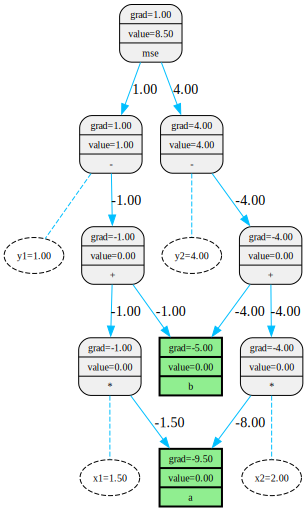

In [4]:
### 计算图膨胀
model = Linear()

# 定义两组数据
x1 = Scalar(1.5, label='x1', requires_grad=False)
y1 = Scalar(1.0, label='y1', requires_grad=False)
x2 = Scalar(2.0, label='x2', requires_grad=False)
y2 = Scalar(4.0, label='y2', requires_grad=False)

loss = mse([model.error(x1, y1), model.error(x2, y2)])
loss.backward()

draw_graph(loss, 'backward')

现在我来简单解释一下这个图片，通过第 10 节我们知道，这个图是反向传播的展示图，这个图主要分为两部分： $x1$ 、$y1$ 到 mse 和 $x2$ 、 $y2$ 到 mse，我们选其一解释。

正向传播是从下到上看的，我们这个模型是一个线性模型，其公式为： $ y = ax + b $ 。刚开始，我们输入了 $x1$ ， $x1$ 与图中的 $a$ 做乘法运算形成新节点，我们称呼这个节点为 $ax_1$ ，随后 $ax_1$ 与 $b$ 做加法运算产生新节点，这个节点我们叫做 $ ax_1 + b $ ，已是模型预测输出的结果值，但是我们要训练模型，要计算预测值和真实值 $y1$ 的误差，于是将这个节点的值与 $y1$ 做减法运算给到 mse 。mse 要做的是计算目前批次输入的所有 x 值与真实值的误差，于是同理 $x2$ 最终的计算结果页会给到 mse 。


代码中，mse 损失器的计算公式如下：

$MSE(a, b) = \frac{1}{n} \sum_{i=1}^n (y_i - ax_i - b)^2$

代码是这样书写的：

```python
for item in errors:
    value += item.value ** 2 / n
    wrt[item] = 2 / n * item.value
    requires_grad = requires_grad or item.requires_grad
```

`value` 是最终所有差值累加的结果，`wrt` 是保存该函数对于每个输入的偏导，不难可以推导出其偏导：

$
\begin{aligned}
\text{mse} &= \frac{1}{n} \sum_{i=1}^{n} \text{loss}_i^2 = \frac{1}{n} \left( \text{loss}_1^2 + \text{loss}_2^2 + \text{loss}_3^2 + \cdots + \text{loss}_n^2 \right) \\
\frac{\partial \text{mse}}{\partial \text{loss}_i} &= \frac{1}{n} \cdot 2 \cdot \text{loss}_i
\end{aligned}
$

所以从上图我们会发现一个问题，当输入的批次内的样本输入的样本数量非常大的时候，就会出现计算图膨胀的问题！这十分消耗内存。

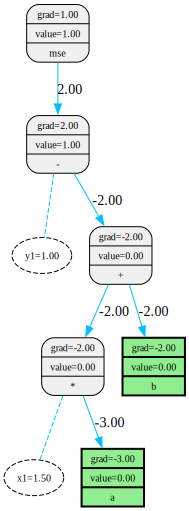

In [6]:
### 梯度积累的计算：将整个计算图拆成若干个计算图进行计算，并累计梯度，这可以解决计算图膨胀的问题
model = Linear()

loss = mse([model.error(x1, y1)])
loss.backward()

draw_graph(loss, 'backward')

观察上述的图像，我们发现最终给到 $a$ 的梯度是 $-3$ 而不是我们之前计算图中的 $-1.5$ ，这是因为 mse 损失器中的导数除了一个 $n$ ，想要正确累积梯度，需要进行额外的加工计算，这我们使用的 mse 损失器比较简单，所以直接除一个样本数量即可。

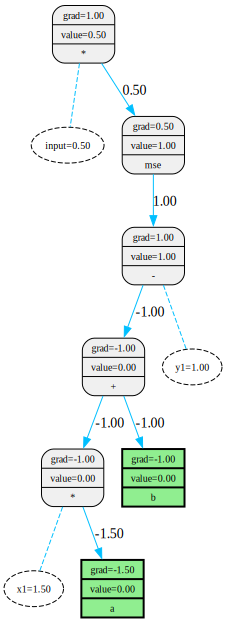

In [7]:
model = Linear()

loss = 0.5 * mse([model.error(x1, y1)])  # 这里乘了 0.5 代表除了样本数量
loss.backward()

draw_graph(loss, 'backward')

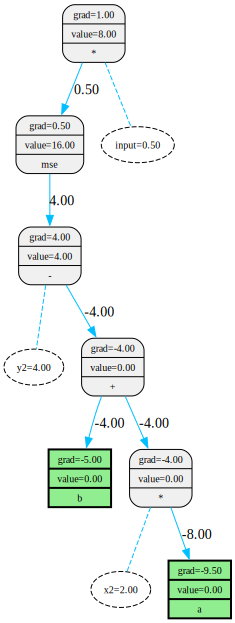

In [8]:
# 进行第二次传播（这就解释了为什么 Pytorch 中需要手动清空之前的梯度，每次我们在新的一轮进行训练时总是要手动清空梯度，不清空为的就是梯度积累）
loss = 0.5 * mse([model.error(x2, y2)])  # 这里乘了 0.5 代表除了样本数量
loss.backward()

draw_graph(loss, 'backward')

In [11]:
# 梯度积累的训练方式
model = Linear()

batch_size = 20
learning_rate = 0.1

gradient_accu_iter = 4  # 累计的次数

# 写的代码和视频里不一样，可能有错误，要保证梯度累计的次数是批量大小的因数

for t in range(20):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]

    for gt in range(gradient_accu_iter):
        xxx = xx[gt * gradient_accu_iter: (gt + 1) * gradient_accu_iter]
        yyy = yy[gt * gradient_accu_iter: (gt + 1) * gradient_accu_iter]
        loss = mse([model.error(_x, _y) for _x, _y in zip(xxx, yyy)])
        loss = loss * (1 / gradient_accu_iter)
        loss.backward()

    model.a -= learning_rate * model.a.grad
    model.b -= learning_rate * model.b.grad

    model.a.grad = 0.0
    model.b.grad = 0.0

    print(model.string())

y = 3.33 * x + -2.09
y = 3.64 * x + -2.33
y = 3.37 * x + -2.02
y = 2.97 * x + -1.28
y = 2.77 * x + -0.27
y = 2.95 * x + 1.00
y = 3.68 * x + 2.47
y = 4.98 * x + 4.04
y = 6.61 * x + 5.42
y = 8.18 * x + 6.46
y = 9.42 * x + 5.68
y = 9.76 * x + 5.40
y = 9.89 * x + 5.26
y = 9.89 * x + 5.27
y = 9.89 * x + 5.26
y = 9.88 * x + 5.22
y = 9.87 * x + 5.18
y = 9.86 * x + 5.18
y = 9.87 * x + 5.19
y = 10.00 * x + 5.28


# 参数冻结和随机失活

参数冻结通常是为了在训练过程中防止特定层的权重被更新。这在迁移学习或微调预训练模型时尤其有用，当我们只想训练模型的一部分时，可以通过冻结其他部分来加速训练过程并减少过拟合的风险。在 Pytorch 中就是把 requires_grad 设置为 False 。

随机失活（dropout）是对具有深度结构的人工神经网络进行优化的方法，在学习过程中通过将隐含层的部分权重或输出随机归零，降低节点间的相互依赖性从而实现神经网络的正则化，降低其结构风险。做法是对某些节点的权重乘以 0 ，使其传播时梯度就为 0 了。
